<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>
<br></br>

# Topic Modeling
## *Data Science Unit 4 Sprint 1 Assignment 4*

Analyze a corpus of Amazon reviews from Unit 4 Sprint 1 Module 1's lecture using topic modeling: 

- Fit a Gensim LDA topic model on Amazon Reviews
- Select appropriate number of topics
- Create some dope visualization of the topics
- Write a few bullets on your findings in markdown at the end
- **Note**: You don't *have* to use generators for this assignment

In [2]:
import pandas as pd

# Start by importing through the dataframe
df = pd.read_csv('data/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv')

In [3]:
# Lets see what I'm working with
df.head()

# So it looks like I can use a variety of things to get data out of
# I'm probably gonna stick with just the reviews.text column for ease of use
# maybe later if I get to it I'll concat reviews.title onto the front
# to get more keywords.

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."
3,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Seem to work as well as name brand batteries a...,... as well as name brand batteries at a much ...,Bymark sexson,"https://www.barcodable.com/upc/841710106442,ht..."
4,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,These batteries are very long lasting the pric...,... batteries are very long lasting the price ...,Bylinda,"https://www.barcodable.com/upc/841710106442,ht..."


In [9]:
df['reviews.text'][0]

'I order 3 of them and one of the item is bad quality. Is missing backup spring so I have to put a pcs of aluminum to make the battery work.'

In [7]:
# Import my stuff

import numpy as np
import gensim
import spacy

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora

from gensim.models.ldamulticore import LdaMulticore

In [8]:
# I'm gonna use Spacy to tokenize
nlp = spacy.load("en_core_web_lg")

In [10]:
# set up tokens list
tokens = []

# use Spacy to tokenize the reviews
for doc in nlp.pipe(df['reviews.text']):
    
    doc_tokens = []
    
    for token in doc: # make sure they're not stopwords or punctuation
        if (token.is_stop != True) and (token.is_punct !=True):
            doc_tokens.append(token.lemma_.strip())
            
    tokens.append(doc_tokens)

tokens[:5]

[['order',
  '3',
  'item',
  'bad',
  'quality',
  'miss',
  'backup',
  'spring',
  'pc',
  'aluminum',
  'battery',
  'work'],
 ['bulk', 'expensive', 'way', 'product', 'like'],
 ['Duracell', 'price', 'happy'],
 ['work', 'brand', 'battery', 'well', 'price'],
 ['battery', 'long', 'last', 'price', 'great']]

In [12]:
# now to take the tokens from Spacy and put it into Gensim

# Create the corpora dictionary with our lists of tokens
id2word = corpora.Dictionary(tokens)

In [13]:
# How many keys do we have to start with?
len(id2word.keys())

9727

In [14]:
# Filter the keys for better results
id2word.filter_extremes(no_below=5, no_above=.95)

In [15]:
# How many keys do we have now?
len(id2word.keys())

3087

In [16]:
# Construct the corpora and process it
corpora = [id2word.doc2bow(doc) for doc in tokens]
lda = LdaMulticore(corpus=corpora,
                  id2word=id2word,
                  num_topics=15, 
                  passes=50)

# See what we get as a result
lda.print_topics()

[(0,
  '0.104*"tablet" + 0.024*"good" + 0.020*"Amazon" + 0.016*"price" + 0.016*"app" + 0.016*"need" + 0.016*"Google" + 0.015*"want" + 0.014*"expect" + 0.012*"store"'),
 (1,
  '0.066*"game" + 0.056*"book" + 0.049*"watch" + 0.046*"read" + 0.043*"movie" + 0.039*"play" + 0.035*"tablet" + 0.030*"video" + 0.029*"love" + 0.025*"great"'),
 (2,
  '0.032*"charge" + 0.023*"get" + 0.022*"card" + 0.019*"$" + 0.019*"buy" + 0.013*"add" + 0.012*"Kindle" + 0.011*"memory" + 0.011*"GB" + 0.010*"day"'),
 (3,
  '0.158*"love" + 0.081*"buy" + 0.057*"gift" + 0.042*"Christmas" + 0.033*"use" + 0.031*"daughter" + 0.028*"tablet" + 0.024*"get" + 0.023*"purchase" + 0.022*"great"'),
 (4,
  '0.127*"old" + 0.120*"year" + 0.040*"love" + 0.035*"tablet" + 0.029*"2" + 0.028*"3" + 0.025*"buy" + 0.022*"4" + 0.020*"5" + 0.019*"use"'),
 (5,
  '0.135*"work" + 0.051*"app" + 0.040*"tablet" + 0.033*"amazon" + 0.022*"great" + 0.020*"good" + 0.020*"fine" + 0.020*"like" + 0.018*"little" + 0.016*"load"'),
 (6,
  '0.049*"use" + 0.027*

In [17]:
# display that in a prettier way

import re
words = [re.findall('"([^"]*)"',t[1]) for t in lda.print_topics()]
topics = [' '.join(t[0:5]) for t in words]
for id, t in enumerate(topics): 
    print(f"------ Topic {id} ------")
    print(t, end="\n\n")

------ Topic 0 ------
tablet good Amazon price app

------ Topic 1 ------
game book watch read movie

------ Topic 2 ------
charge get card $ buy

------ Topic 3 ------
love buy gift Christmas use

------ Topic 4 ------
old year love tablet 2

------ Topic 5 ------
work app tablet amazon great

------ Topic 6 ------
use easy device app tablet

------ Topic 7 ------
great good price product tablet

------ Topic 8 ------
Kindle Fire easy fire screen

------ Topic 9 ------
read light size easy book

------ Topic 10 ------
battery long life last use

------ Topic 11 ------
battery price long great good

------ Topic 12 ------
kid tablet great love child

------ Topic 13 ------
Amazon buy come product time

------ Topic 14 ------
purchase need charge pleased set



In [18]:
# Visualize the topics
import pyLDAvis.gensim

pyLDAvis.enable_notebook()

In [19]:
pyLDAvis.gensim.prepare(lda,corpora,id2word)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10    -0.205580 -0.123587       1        1  12.976988
11    -0.311451  0.097224       2        1   9.110950
12     0.141096  0.095736       3        1   8.703386
7     -0.182323  0.259799       4        1   7.603494
6      0.059377 -0.083747       5        1   7.098201
9      0.070034 -0.082403       6        1   6.914526
8      0.122363 -0.037974       7        1   6.498747
13    -0.108200 -0.125619       8        1   6.477360
3      0.204081  0.117485       9        1   6.021585
1      0.146391  0.078807      10        1   5.494372
4      0.183715  0.075171      11        1   5.339051
0     -0.069970  0.020371      12        1   5.289801
2     -0.018391 -0.196010      13        1   4.945132
5     -0.072598  0.061573      14        1   4.141881
14     0.041457 -0.156825      15        1   3.384532, topic_info=         Term         Freq        Total Category  logprob  loglift
3     battery  9449.000000  9449.000000  Default  30.0000  30.0000
84       love  5990.000000  5990.000000  Default  29.0000  29.0000
18      price  5077.000000  5077.000000  Default  28.0000  28.0000
10       work  4143.000000  4143.000000  Default  27.0000  27.0000
21      great  8868.000000  8868.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
151      time    81.331131  2464.874512  Topic15  -4.8834  -0.0254
1788   kindle    72.932243  1452.916748  Topic15  -4.9924   0.3942
344     right    64.219261   524.124146  Topic15  -5.1197   1.2865
1339      app    66.247490  2415.532959  Topic15  -5.0886  -0.2103
8     quality    64.814255  1260.813965  Topic15  -5.1104   0.4180

[1091 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
2398      6  0.029688        $
2398     10  0.038823        $
2398     12  0.260344        $
2398     13  0.669129        $
376       1  0.255021        1
...     ...       ...      ...
2623     13  0.150124  youtube
2623     14  0.045037  youtube
1086      3  0.008080       yr
1086      9  0.040400       yr
1086     11  0.949395       yr

[2860 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 12, 13, 8, 7, 10, 9, 14, 4, 2, 5, 1, 3, 6, 15])

In [21]:
# Put all of this info in to a dataframe
dist_df = [lda[d] for d in corpora]

# Filter the info
def update(doc):
        d_dist = {k:0 for k in range(0,15)}
        for t in doc:
            d_dist[t[0]] = t[1]
        return d_dist
    
new_dist_df = [update(d) for d in dist_df]

# covert to Dataframe
doc_topics = pd.DataFrame.from_records(new_dist_df)
doc_topics.columns = topics

doc_topics.head()

,tablet good Amazon price app,game book watch read movie,charge get card $ buy,love buy gift Christmas use,old year love tablet 2,work app tablet amazon great,use easy device app tablet,great good price product tablet,Kindle Fire easy fire screen,read light size easy book,battery long life last use,battery price long great good,kid tablet great love child,Amazon buy come product time,purchase need charge pleased set
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.370296,0.214728,0.000000,0.348263,0.000000
1,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.183727,0.011111,0.011111,0.011111,0.671824,0.011111,0.011111,0.011111
2,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.016667,0.403698,0.016667,0.016667,0.016667,0.379628,0.016667,0.016667,0.016667
3,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.844444,0.011111,0.011111,0.011111
4,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.011111,0.231424,0.624130,0.011111,0.011111,0.011111


In [22]:
# get the counts of the primary topics
doc_topics['primary_topic'] = doc_topics.idxmax(axis=1)
doc_topics['primary_topic'].value_counts()

great good price product tablet     4308
battery price long great good       4254
battery long life last use          3325
kid tablet great love child         2405
love buy gift Christmas use         2335
Kindle Fire easy fire screen        1636
read light size easy book           1508
use easy device app tablet          1407
game book watch read movie          1253
tablet good Amazon price app        1207
Amazon buy come product time        1134
old year love tablet 2              1128
work app tablet amazon great        1107
charge get card $ buy                810
purchase need charge pleased set     515
Name: primary_topic, dtype: int64

In [23]:
# Next, I'll get the coherence values for my data
# From this, I should be able to graph coherence for each number
# of topics

from gensim.models.coherencemodel import CoherenceModel

def compute_coherence_values(dictionary, corpus, limit, start=2, step=3, passes=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    limit : Max num of topics
    passes: the number of times the entire lda model & coherence values are calculated

    Returns:
    -------
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    
    for iter_ in range(passes):
        for num_topics in range(start, limit, step):
            model = LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=dictionary, workers=12)
            coherencemodel = CoherenceModel(model=model,dictionary=dictionary,corpus=corpus, coherence='u_mass')
            coherence_values.append({'pass': iter_, 
                                     'num_topics': num_topics, 
                                     'coherence_score': coherencemodel.get_coherence()
                                    })

    return coherence_values

In [24]:
# Running this might take a while
coherence_values = compute_coherence_values(dictionary=id2word, 
                                                        corpus=corpora,
                                                        start=3, 
                                                        limit=40, 
                                                        step=2,
                                                        passes=1)

In [25]:
topic_coherence = pd.DataFrame.from_records(coherence_values)
topic_coherence.head()

,pass,num_topics,coherence_score
0,0,3,-2.381634
1,0,5,-2.351048
2,0,7,-2.354701
3,0,9,-2.360507
4,0,11,-2.359254


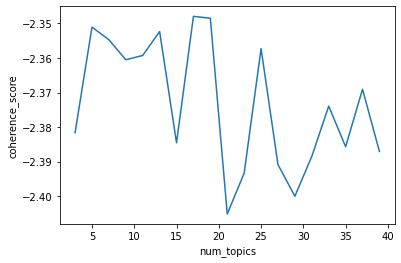

In [26]:
# Display the results
import seaborn as sns
 
ax = sns.lineplot(x="num_topics", y="coherence_score", data=topic_coherence)

## Findings

Topics:
* Topic 1: "game book watch read movie" has a high relation to the word "battery"
* Topic 2: "charge get card $ buy" also corrosponds to "battery"
* Topic 3: "love buy gift Christmas use" has a high relation to the words "kid", "tablet", and "love"
* Topic 9: "read light size easy book" likewise corresponds to words like "love", "gift", and "Christmas"
* Topics 5: "work app tablet amazon great" and 6: "use easy device app tablet" are similar in terms of their principal components
* Topics 3, 10, 11, and 9 are also very similar in terms of their principal components
* Overall, some of the most prominent terms are the words "battery", "great", "tablet", "good", "love"

Topic Coherence:

Topic Coherence fluctuates wildly between -2.35 and -2.4, with it's peak at about 16 topics and it's lowest point at about 21.


## Stretch Goals

* Incorporate Named Entity Recognition in yotopic_coherenceis
* Incorporate some custom pre-processing from our previous lessons (like spacy lemmatization)
* Analyze a dataset of interest to you with topic modeling